# Langevin Gradient Parallel Tempering

*by Chandra et al < arXiv:1811.04343v1 >*

With respect to showing the details of Implementation of the parallel tempering algorithm with Langevin Gradients, we will use a multimodal Gaussian distribution, as shown below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(747) #!!

In [2]:
y1 = 1*np.random.normal(2, 1, [10000])

In [3]:
y2 = 1*np.random.normal(-2, 1, [10000])

In [4]:
y = np.r_[y1,y2]

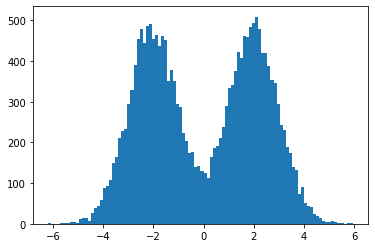

In [5]:
uwuwu = plt.hist(y, bins = 100)

In [6]:
def Normal(x, mu = 0, sig2 = 1):
    return (1/(tf.sqrt(2*np.pi*sig2))) * tf.exp(-0.5*(tf.pow((x - mu),2)/sig2))


In [7]:
x = tf.Variable(np.linspace(-6,6,1000), dtype = tf.float32)

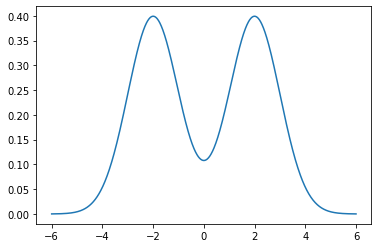

In [8]:
plt.plot(x.numpy(), 1*Normal(x,-2,1) + 1*Normal(x, 2,1))

Therefore we have a bimodal distribution modelled as :

$1\times N(2,1) + 1 \times N(-2,1)$

Now, imagine we only have a part of this as our Data $D$, say, out of original 20,000 data points, we have only 5,000 of them, randomly selected as shown below.

In [9]:
DATA = tf.Variable(np.random.permutation(y)[:5000], dtype = tf.float32)

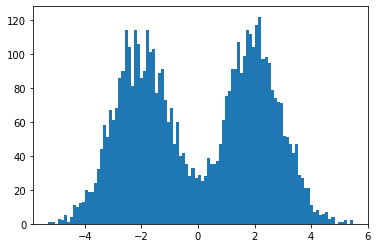

In [10]:
uwu = plt.hist(DATA.numpy(), bins = 100)

Now, we model the problem as the following:

$y_i \sim c_1 N(\mu_1, 1) + c_2N(\mu_2, 1)$ (Likelihood)

where, $c_1, c_2, \mu_1, \mu_2$ are the parameters which needs to be estimated.

## Prior

Assuming Independent *apriori* with each being  a $Normal$ distribution with $\mu  = 0$ and $\sigma = 1$

Thus we get the prior $P\left( \theta\right)$ as:

$P(\theta) = \left(\frac{1}{\sqrt{2\pi}}\right)^4 \exp\left(   -\frac{c_1^2}{2}-\frac{c_2^2}{2}-\frac{\mu_1^2}{2}-\frac{\mu_2^2}{2}    \right)$

In [11]:
def Prior(c1,c2,mu1,mu2):
    return (1/(tf.pow(2*np.pi, 2))) * tf.exp(-0.5*(c1**2 + c2**2 + mu1**2 + mu2**2))


## Likelihood

As shown earlier, the likelihood function is:

$P(D | \theta ) = c_1 N(\mu_1, 1) + c_2N(\mu_2, 1)$

In [12]:
def Likelihood(x, c1, c2, mu1, mu2):
    return c1*Normal(x, mu1, 1) + c2*Normal(x, mu2, 1)

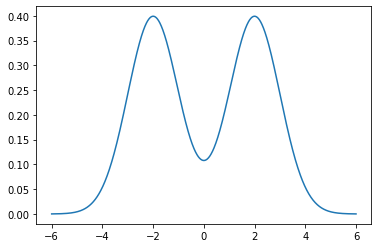

In [13]:
plt.plot(x.numpy(), Likelihood(x, 1,1,-2,2))

## Sampling Algorithm and Gradient Evaluation

First, we will implement the MHPT and it's helper functions

We have 4 parameters here : $c_1, c_2, \mu_1, \mu_2$

We have also set our Likelihood for the data and our Joint Prior for all the parameters.

Now we need to set the Proposal Distribution, which will be the following Normal Distribution:

$\theta^p \sim N(\theta_{prev}, \sigma^2I)$

where $\sigma$ is already set to some default value

So first, we'll make a class for each replica and the information regarding it.

### Langevin Gradient Parameter Update

In [14]:
def nparray_to_arrayoftensors(nparray, dtype = tf.float32):
    
    holder = np.array([None for _ in range(nparray.shape[0])])
    for i,x in enumerate(nparray):
        holder[i] = tf.Variable(x, dtype = dtype)
        
    return holder

In [15]:
a = nparray_to_arrayoftensors(np.array([1,1,1,1]))
a

array([<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
       <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
       <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
       <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>],
      dtype=object)

In [16]:
def arrayoftensors_to_nparray(arrayoftensors):
    
    nptheta_new = np.zeros_like(arrayoftensors)
    for i,param in enumerate(arrayoftensors):
        nptheta_new[i] = param.numpy()

    return nptheta_new

In [17]:
arrayoftensors_to_nparray(a)

array([1.0, 1.0, 1.0, 1.0], dtype=object)

In [18]:
def LangevinUpdate(x, paramvector, lr):
    
    """
    x : Data Vector of tf.Variable
    paramvector : A vector containing the last values for each parameter
    lr : Learning Rate.
    """
    
    print("Langevin update")
    
    paramvector = nparray_to_arrayoftensors(paramvector, tf.float32)
        
    with tf.GradientTape() as tape:
         log_unnormalPost = tf.add(tf.math.log(Prior(paramvector[0], paramvector[1], paramvector[2], paramvector[3])) ,\
                tf.reduce_sum(tf.math.log(Likelihood(x, paramvector[0], paramvector[1], paramvector[2], paramvector[3]))))
    
    print("log_unnormalPost: ", log_unnormalPost)
    gradients = tape.gradient(log_unnormalPost, [paramvector[0], paramvector[1], paramvector[2], paramvector[3]])

    print("Gradient: ", arrayoftensors_to_nparray(gradients))
    theta_new = paramvector + lr*np.array(gradients) +\
                                        np.random.multivariate_normal(np.zeros([paramvector.shape[0]]), 2*lr*np.eye(N = paramvector.shape[0], M= paramvector.shape[0])) 
    
    #Converting to numpy
    
    nptheta_new = arrayoftensors_to_nparray(theta_new)
    
    return nptheta_new.astype(np.float64)
    
    

In [19]:
LangevinUpdate(DATA, np.array([1,1,1,1]), 0.001)

Langevin update
log_unnormalPost:  tf.Tensor(-16203.57, shape=(), dtype=float32)
Gradient:  [ 2499.     2499.    -2490.736 -2490.736]


array([ 3.53711724,  3.49711752, -1.57755423, -1.56772387])

### Random Walk Parameter Update

In [20]:
def RWMH_Update(x, paramvector, variance):
    
    """
    Update the paramters using Metropolis-Hastings Random Walker (only 1 unit walk on each call).
    
    Since it's a random walker, therefore it uses Multivariate Normal distribution
    centered at theta_prev with constant diagonal Covariance Matrix. 
    
    paramvector' each location is supposed to be a tf.Variable type holding the np value.
    
    """
    print("RWMH Update")
    

        
    #Draw Candidate from Proposal
    paramvector = paramvector.astype(np.float32)
    theta_star = tf.Variable(np.random.multivariate_normal(mean = paramvector, cov = variance*np.eye(paramvector.shape[0])), dtype = tf.float32)
    
    paramvector = nparray_to_arrayoftensors(paramvector)
        
    #Calculate Metropolis Hastings Acceptance Ratio 
    log_alpha = tf.add(tf.math.log(Prior(theta_star[0], theta_star[1], theta_star[2], theta_star[3])) ,\
                        tf.reduce_sum(tf.math.log(Likelihood(x, theta_star[0], theta_star[1], theta_star[2], theta_star[3])))) \
                               - tf.add(tf.math.log(Prior(paramvector[0], paramvector[1], paramvector[2], paramvector[3])) ,\
                                    tf.reduce_sum(tf.math.log(Likelihood(x, paramvector[0], paramvector[1], paramvector[2], paramvector[3]))))
    
    alpha = min(1,tf.exp(log_alpha))
    
    
    #Accept or Reject based on alpha
    
    accept = False
    
    trial = np.random.uniform(0,1)
    
    if trial < alpha:
        #Then Accept
        theta_new = theta_star.numpy()
        accept = True
        print("-----Accepted")
    
    else:
        #Reject
        theta_new = paramvector
        
        print("-----Rejected")
        #Converting to numpy
        theta_new = arrayoftensors_to_nparray(theta_new)

        
    return theta_new

In [21]:
(RWMH_Update(DATA, np.array([1,1,1,1]), 0.1))

RWMH Update
-----Accepted


array([0.8469697, 0.5664272, 0.5418376, 0.5065997], dtype=float32)

### Replica Class

In [22]:
class Replica:
    
    def __init__(self, ID, Temp, ParamMat, SwapInterval, LGfreq, LG = True):
        
        """
        ID : the ID by which you wish to identify this Replica.
        Temp : Temperature of this Replica.
        ParamMat : A 2D numpy array where no. of columns == no.of parameters, in this, the rows will indicate the parameter
                   values at all iterations, thus last row will be the latest parameter values and similarily the first row will
                   be the first iteration's result for the parameter values.
        SwapInterval : The length of iterations to run each replica before Swap Procedure.
        LGfreq : The frequency of using Langevin Gradient based parameter update.
        # GlobalExploring : Whether to explore globally or locally, this just affects the temperature assignment as in the paper.
        LG : Whether to use Langevin gradient ascent for parameter update or not (default TRUE)
        """
        
        self.ID = ID
        self.Temp = Temp
        self.ParamMat = ParamMat
        self.SwapInterval = SwapInterval
#         self.LG = LG
#         self.LGfreq = LGfreq
        
    
    #def TemperatureLadder(self) ---> It would be set in the final class.
    
    def ReplicaSampler(self, DATA, lr):
        """
        Samples from the Chain in this replica.
        
        DATA: Numpy vector containing the values
        """

        l = np.random.uniform(0,1)
        DataVariable = tf.Variable(DATA, dtype = tf.float32)
        
#        if ((self.LG is True) and l < self.LGfreq):


############################### ONLY LANGEVIN UPDATE, FOR NOW #####################################
            
        DataVariable = tf.Variable(DATA, dtype = tf.float32)

        NewParams = LangevinUpdate(DataVariable, np.squeeze(self.ParamMat[-1,:]), lr = lr)
            
#         else :
            
#             DataVariable = tf.Variable(DATA, dtype = tf.float32)
        
#             NewParams = RWMH_Update(DataVariable, np.squeeze(self.ParamMat[-1,:]), 0.1)
            
    
        
    
    
        #Since we have already accepted(or rejected) the proposals, so we're done.        
        
        #Accept or Reject based on alpha
    
        
        paramvector = self.ParamMat[-1,:]
        variance = 0.01
        
        paramvector = paramvector.astype(np.float32)
        theta_star = tf.Variable(np.random.multivariate_normal(mean = paramvector, cov = variance*np.eye(paramvector.shape[0])), dtype = tf.float32)

        paramvector = nparray_to_arrayoftensors(paramvector)

        
        #Calculate Metropolis Hastings Acceptance Ratio 
        log_alpha = (1/self.Temp) * ( tf.add(tf.math.log(Prior(theta_star[0], theta_star[1], theta_star[2], theta_star[3])) ,\
                                        tf.reduce_sum(tf.math.log(Likelihood(DataVariable, theta_star[0], theta_star[1], theta_star[2], theta_star[3])))) \
                                               - tf.add(tf.math.log(Prior(paramvector[0], paramvector[1], paramvector[2], paramvector[3])) ,\
                                                    tf.reduce_sum(tf.math.log(Likelihood(DataVariable, paramvector[0], paramvector[1], paramvector[2], paramvector[3])))) )

        
        
        
        
        alpha = min(1,tf.exp(log_alpha))

        
        
    
        accept = False

        trial = np.random.uniform(0,1)

        if trial < alpha:
            #Then Accept
            theta_new = NewParams
            accept = True
            print("-----Accepted")

        else:
            #Reject
            theta_new = self.ParamMat[-1,:]
            print("-----Rejected")
    
        return theta_new
    
    def RunChain(self, DATA, lr):
        
        """
        Updates the ParamMat with new Parameters
        """
        
        for k in range(self.SwapInterval):
            
            NewParams = self.ReplicaSampler(DATA, lr)
            self.ParamMat = np.r_[self.ParamMat, [NewParams]]
        
        return True

In [23]:
replica = Replica(1,70,np.array([[1,1,1,1]]), 10, 0.6, True)

#### *Notice how increase in Temperature increases the Movement of Chain down below*

In [24]:
replica.ReplicaSampler(DATA.numpy(), lr = 0.00001)

Langevin update
log_unnormalPost:  tf.Tensor(-16203.57, shape=(), dtype=float32)
Gradient:  [ 2499.     2499.    -2490.736 -2490.736]
-----Accepted


array([1.02749419, 1.02299535, 0.97450131, 0.97187376])

In [25]:
result = replica.RunChain(DATA.numpy(), 0.00001)

Langevin update
log_unnormalPost:  tf.Tensor(-16203.57, shape=(), dtype=float32)
Gradient:  [ 2499.     2499.    -2490.736 -2490.736]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-15982.322, shape=(), dtype=float32)
Gradient:  [ 2448.3076  2432.5583 -2471.3499 -2405.937 ]
-----Rejected
Langevin update
log_unnormalPost:  tf.Tensor(-15982.322, shape=(), dtype=float32)
Gradient:  [ 2448.3076  2432.5583 -2471.3499 -2405.937 ]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-15752.2295, shape=(), dtype=float32)
Gradient:  [ 2394.5176  2372.535  -2431.267  -2329.6174]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-15529.612, shape=(), dtype=float32)
Gradient:  [ 2356.0176  2320.7239 -2402.337  -2223.5327]
-----Rejected
Langevin update
log_unnormalPost:  tf.Tensor(-15529.612, shape=(), dtype=float32)
Gradient:  [ 2356.0176  2320.7239 -2402.337  -2223.5327]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-15338.798, shape=(), dtype=float32)
Grad

In [26]:
replica.ParamMat

array([[1.        , 1.        , 1.        , 1.        ],
       [1.02041662, 1.02756381, 0.97586375, 0.98247647],
       [1.02041662, 1.02756381, 0.97586375, 0.98247647],
       [1.04446995, 1.05237639, 0.95106292, 0.9607448 ],
       [1.06391239, 1.07342327, 0.92077744, 0.93708831],
       [1.06391239, 1.07342327, 0.92077744, 0.93708831],
       [1.08468163, 1.09691179, 0.89467412, 0.92537934],
       [1.10710752, 1.11948574, 0.8714239 , 0.89943713],
       [1.10710752, 1.11948574, 0.8714239 , 0.89943713],
       [1.10710752, 1.11948574, 0.8714239 , 0.89943713],
       [1.10710752, 1.11948574, 0.8714239 , 0.89943713]])

#### Note that I am not doing the Acceptance Criterion again as it is incorporated in the RWMH itself.

## Parallel Tempering Class

In [27]:
class ParallelTempering:
    def __init__(self, NumSamples, nChains, Tmax, SwapInterval, DATA, lr):
        
        """
        Parallel Tempering as in <arXiv:1811.04343v1> Chandra et al
        
        Make sure you put learning rate (lr) as low as possible as there's a big chance of gradient 
        placeholder underflow.
        
        """
        
        
        self.NumSamples = NumSamples
        self.nChains = nChains
        self.Tmax = Tmax
        self.Replicas = None
        self.SwapInterval = SwapInterval
        self.DATA = DATA #Numpy vector
        self.lr = lr #Learning Rate
        
    def CreateGeometricBetaLadder(self):
        
        """
        Creates a Geometric Temperature Assignment
        
        Beta is the inverse Temperature
        """
        #Common ratio
        r = np.power((1/self.Tmax),1/(self.nChains-1))
        
        Betas = [None for _ in range(self.nChains)]
        
        for i in range(self.nChains):
            Betas[i] = np.power(r,i)
            
        assert len(Betas)==self.nChains
        
        return Betas
    
    def ReplicaMaker(self):
        
        """
        Makes the Replica chains and assigns their essential arguments.
        
        Sets self.Replicas a list containing objects of class Replica 
        """
        
        Betas = self.CreateGeometricBetaLadder()
        
        Replicas = [None for _ in range(self.nChains)]
        for i in range(self.nChains):
            
            Replicas[i] = Replica(ID = i, Temp = (1/Betas[i]), SwapInterval = self.SwapInterval,ParamMat = np.random.uniform(-0.1,1,size = [1,4]), LGfreq =  0.6)
                                                                                                        #RANDOM INITIAL PARAMETERS
        self.Replicas = Replicas
    
    def SwapExecuter(self, ID_i, ID_j):
        """
        Swapper no swapping!!
        
        Swaps the Temperature of the i^{th} and j^{th} Replica Chain.
        """
        
        #Calculate Swap Probability
        
        print("Swap PROPOSED between {}th and {}th Chains".format(ID_i, ID_j))
        
        Chain_i = self.Replicas[ID_i]
        Chain_j = self.Replicas[ID_j]
        
        Beta_i = 1/(Chain_i.Temp)
        Beta_j = 1/(Chain_j.Temp)
        
        last_param_i = nparray_to_arrayoftensors(Chain_i.ParamMat[-1,:])
        last_param_j = nparray_to_arrayoftensors(Chain_j.ParamMat[-1,:])
        
        DataVariable = tf.Variable(self.DATA, dtype  = tf.float32)
                
        likel_prior_i = tf.add(tf.math.log(Prior(last_param_i[0], last_param_i[1], last_param_i[2], last_param_i[3])) ,\
                                        tf.reduce_sum(tf.math.log(Likelihood(DataVariable, last_param_i[0], last_param_i[1], last_param_i[2], last_param_i[3]))))
        
        
        
        likel_prior_j = tf.add(tf.math.log(Prior(last_param_j[0], last_param_j[1], last_param_j[2], last_param_j[3])) ,\
                                        tf.reduce_sum(tf.math.log(Likelihood(DataVariable, last_param_j[0], last_param_j[1], last_param_j[2], last_param_j[3]))))
        
        
        print("likel_prior_i:  ", likel_prior_i.numpy())
        print("likel_prior_j:  ", likel_prior_j.numpy())
        
        log_alpha = Beta_i * (likel_prior_j - likel_prior_i) + Beta_j * (likel_prior_i - likel_prior_j)
        
        
        alpha = tf.exp(log_alpha)
        
        alpha = min(1,alpha)
        
        print("alpha:  ", alpha)
        
        trial = np.random.uniform(0,1)
       

        if trial < alpha:
            
            #Perform the Swap
            Chain_i.Temp, Chain_j.Temp = Chain_j.Temp, Chain_i.Temp
            print("Swap PERFORMED between {}th and {}th Chains".format(ID_i, ID_j),end = '\n\n')
        
        print("\n")
            
    def PTExecuter(self):
        """
        Runs all the Chains till the Swap Interval and then proposes swaps between
        random chains.
        """
        
        for z in range(self.NumSamples):
            
            print('\n')
            print("For Sample : {}".format(z))
            print('---------------------------------------------------')
        
            #Run all the chains for SwapInterval period of time
            for i, replica in enumerate(self.Replicas):

                print("Replica '{}' currently running".format(i))
                replica.RunChain(self.DATA, self.lr)
               

            #Propose Swaps to each of the Chains
            for i in range(self.nChains):

                p = [1/self.nChains for _ in range(self.nChains)]

                ReplicaIndices = [j for j in range(self.nChains)]

                proposalChain_i = np.random.choice(ReplicaIndices, p = p)

                if proposalChain_i == i:

                    proposalChain_i = (i+1)%self.nChains #Still feels pretty random to me!

                self.SwapExecuter(self.Replicas[proposalChain_i].ID, self.Replicas[i].ID)
                
            print('\n')
            print('---------------------------------------------------')

            

## Running the Parallel Tempering Chains

*Note that $Max_{samples}$ is only set to small value of 100 so that it does not overflow on the screen in GitHub ipynb viewer.*

Other than that, it works perfectly fine.

In [28]:
pt = ParallelTempering(5, 3, 10000, 50, DATA.numpy(), 0.00001) 

In [29]:
pt.CreateGeometricBetaLadder()

[1.0, 0.01, 0.0001]

In [30]:
pt.ReplicaMaker()

In [31]:
pt.Replicas[0].Temp, pt.Replicas[1].Temp, pt.Replicas[2].Temp

(1.0, 100.0, 10000.0)

In [32]:
pt.PTExecuter()



For Sample : 0
---------------------------------------------------
Replica '0' currently running
Langevin update
log_unnormalPost:  tf.Tensor(-19512.77, shape=(), dtype=float32)
Gradient:  [ 8628.31    8774.235  -2750.0898  1525.5464]
-----Rejected
Langevin update
log_unnormalPost:  tf.Tensor(-19512.77, shape=(), dtype=float32)
Gradient:  [ 8628.31    8774.235  -2750.0898  1525.5464]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-18067.912, shape=(), dtype=float32)
Gradient:  [ 6618.0083  6571.429  -2878.9785  1613.003 ]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-17158.854, shape=(), dtype=float32)
Gradient:  [ 5654.8335  5614.1025 -2972.7922  1735.4911]
-----Accepted
Langevin update
log_unnormalPost:  tf.Tensor(-16406.8, shape=(), dtype=float32)
Gradient:  [ 5017.8013  4946.5605 -3077.3809  1850.2708]
-----Rejected
Langevin update
log_unnormalPost:  tf.Tensor(-16406.8, shape=(), dtype=float32)
Gradient:  [ 5017.8013  4946.5605 -3077.3809  1850.2708]
---

In [33]:
pt.Replicas[2].ParamMat[-1,:]

array([ 3.07977748,  2.93501282,  1.9953742 , -1.95128572])